# Resampling over sample data to verify the functions

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import mean, stdev
from scipy.stats import norm

In [2]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.4.2


In [3]:
# load iris data 
iris = load_iris()
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Text(0.5, 0, 'Sepal Width')

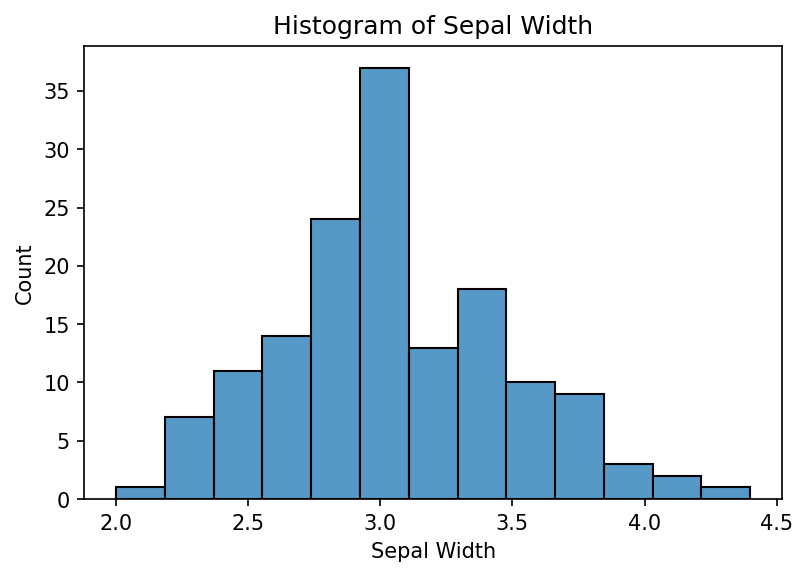

In [4]:
plt.figure(dpi=150)
sns.histplot(df['sepal width (cm)'])
plt.title('Histogram of Sepal Width')
plt.xlabel('Sepal Width')

In [5]:
sepal_width = df['sepal width (cm)']
pop_mean = mean(sepal_width)
print('The mean for sepal width is', pop_mean)

The mean for sepal width is 3.0573333333333332


## From the whole population, we only observe 50 data and we would like to estimate the mean for the whole population from the observed data.

In [6]:
obs_width = np.random.choice(sepal_width, size=50, replace=False)
obs_width

array([3.9, 3.6, 2.8, 2.6, 3.2, 3.7, 3.6, 2.8, 3.5, 2.9, 3. , 3. , 3. ,
       2.8, 4.1, 3.9, 3. , 2.8, 3.4, 3.3, 3.5, 2.8, 2.8, 3.4, 2.7, 3.4,
       2.8, 2.7, 3.1, 2.5, 4.4, 3.4, 3. , 2.5, 3.4, 4. , 2.9, 2.6, 2.8,
       3. , 3. , 3.2, 3. , 2.2, 2.7, 2.2, 2.5, 2.8, 2.3, 2.5])

In [7]:
def bootstrap(data, bootstrap_size, func):
    '''
    data: data to bootstrap
    bootstrap_size: bootstrap size
    func: parameter to estimate
    '''
    n = len(data)
    param_bt = [0] * bootstrap_size
    
    for i in range(bootstrap_size):
        sample_bt = np.random.choice(data, n, replace=True)
        param_bt[i] = func(sample_bt)
        
    return param_bt

In [8]:
width_mean_bt = bootstrap(obs_width, 10000, mean)

In [9]:
def get_CI_normal(data, confidence, est_param):
    '''
    data: data to estimate 
    confidence: width of the interval
    est_param: value of the estimated parameter of the original data
    '''
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = est_param + qnorm * np.std(data, ddof=1) # change degree of freedom
    lower = est_param - qnorm * np.std(data, ddof=1)

    return lower, upper


def get_CI_quantile(data, confidence, est_param):
    
    cutoff = (1 - confidence) / 2
    lower = np.quantile(data, cutoff)
    upper = np.quantile(data, 1 - cutoff)

    return lower, upper


def get_CI_biased_corrected_norm(data, confidence, est_param):
    param_bar = mean(data)
    est_bias = param_bar - est_param
    est_param -= est_bias
    
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = est_param + qnorm * np.std(data, ddof=1)
    lower = est_param - qnorm * np.std(data, ddof=1)
    
    return lower, upper

In [10]:
normal = get_CI_normal(width_mean_bt, 0.95, mean(obs_width))

In [11]:
quantile = get_CI_quantile(width_mean_bt, 0.95, mean(obs_width))

In [12]:
biased = get_CI_biased_corrected_norm(width_mean_bt, 0.95, mean(obs_width))

In [13]:
print('The population mean is', pop_mean, '\n')
print('The observed mean is', mean(obs_width), '\n')
print('Normal CI', normal, '\n')
print('Normal CI', quantile, '\n')
print('Normal CI', biased, '\n')

The population mean is 3.0573333333333332 

The observed mean is 3.06 

Normal CI (2.9247401450786823, 3.195259854921318) 

Normal CI (2.93, 3.198) 

Normal CI (2.925183745078682, 3.1957034549213184) 



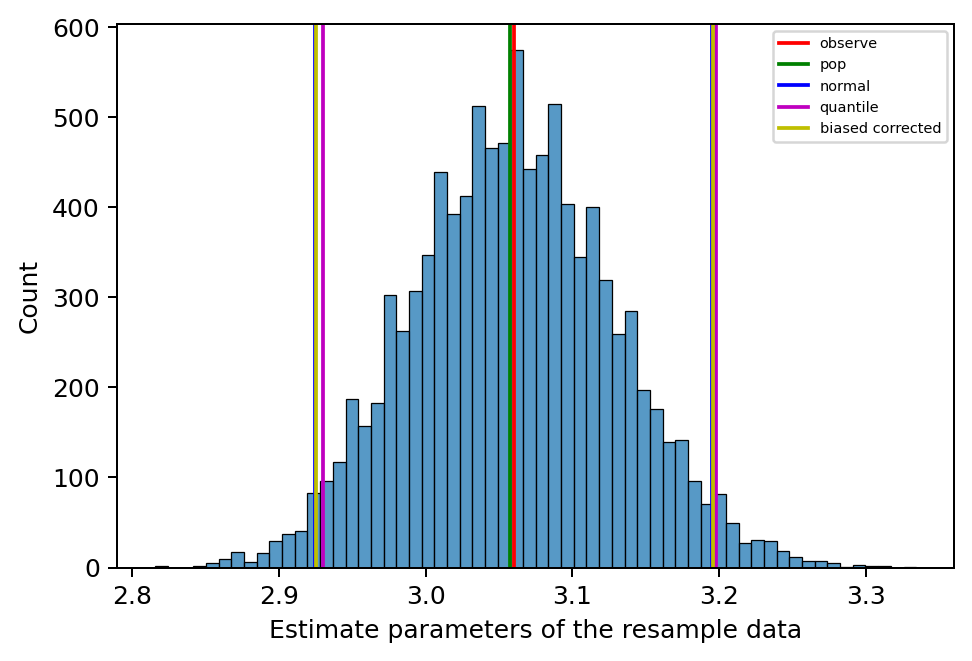

In [14]:
fig = plt.figure(dpi=180)
sns.histplot(width_mean_bt)
plt.axvline(x=mean(obs_width), color = 'r', label = 'observe')
plt.axvline(x=pop_mean, color = 'g', label = 'pop')
plt.axvline(x=normal[0], color = 'b', label = 'normal')
plt.axvline(x=normal[1], color = 'b')
plt.axvline(x=quantile[0], color = 'm', label = 'quantile')
plt.axvline(x=quantile[1], color = 'm')
plt.axvline(x=biased[0], color = 'y', label = 'biased corrected')
plt.axvline(x=biased[1], color = 'y')
plt.legend(loc='best', fontsize = 'xx-small')
plt.xlabel('Estimate parameters of the resample data')
plt.show()

In [15]:
# pseudo values method 
def jackknife(x, func):
    n = len(x)
    pse = []
    idx = np.arange(n)
    
    for i in range(n):
        one_out = x[idx != i]
        pse.append(n * func(x) - (n - 1) * func(one_out))
        
    return pse
        

def jackknife_block(x, func, nfold):
    kf = KFold(n_splits=nfold)
    pse = []
    
    for index,_ in kf.split(x):
        block = x[index]
        pse.append(nfold * func(x) - (nfold - 1) * func(block))
        
    return np.array(pse)


def jk_get_CI(x, confidence):
    
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = mean(x) + qnorm * np.std(x, ddof=1) / sqrt(len(x)) # change degree of freedom
    lower = mean(x) - qnorm * np.std(x, ddof=1) / sqrt(len(x))

    return lower, upper

In [16]:
jk = jackknife(obs_width, mean)
jk_CI = jk_get_CI(jk, 0.95)

In [17]:
jk_block = jackknife_block(obs_width, mean, nfold=5)
jk_block_CI = jk_get_CI(jk_block, 0.95)

In [18]:
print('The population mean is', pop_mean, '\n')
print('The observed mean is', mean(obs_width), '\n')
print('Normal CI by Jackknife is', jk_CI, '\n')
print('Normal CI by Jackknife Block is', jk_block_CI, '\n')

The population mean is 3.0573333333333332 

The observed mean is 3.06 

Normal CI by Jackknife is (2.9226026703150536, 3.1973973296849474) 

Normal CI by Jackknife Block is (2.8310111074692172, 3.2889888925307846) 



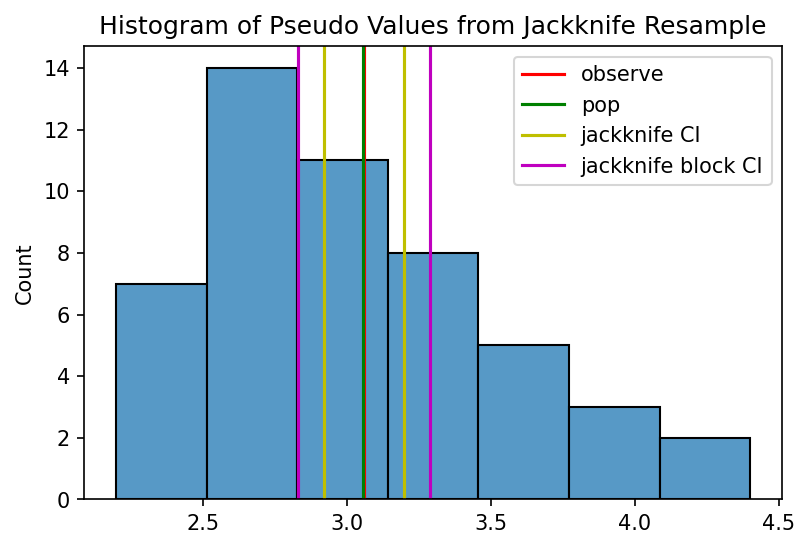

In [19]:
fig2 = plt.figure(dpi=150)
sns.histplot(jk)
plt.axvline(x=mean(obs_width), color = 'r', label = 'observe')
plt.axvline(x=pop_mean, color = 'g', label = 'pop')
plt.axvline(x=jk_CI[0], color = 'y', label = 'jackknife CI')
plt.axvline(x=jk_CI[1], color = 'y')
plt.axvline(x=jk_block_CI[0], color = 'm', label = 'jackknife block CI')
plt.axvline(x=jk_block_CI[1], color = 'm')
plt.legend(loc=0)
plt.title('Histogram of Pseudo Values from Jackknife Resample')
plt.show()

In [21]:
def get_bt_coverage(x, est_function, CI_function, confidence, bootstrap_size):
    
    resample_data = bootstrap(x, bootstrap_size, est_function)
    lower, upper = CI_function(resample_data, confidence, est_function(x))

    return lower, upper

def get_jk_coverage(x, est_function, confidence, nfold=None):
    
    if nfold is not None:
        resample_data = jackknife_block(x, est_function, nfold)
    else:
        resample_data = jackknife(x, est_function)

    lower, upper = jk_get_CI(resample_data, confidence)
    
    return lower, upper

In [27]:
def bt_replicate(data, size, pop_value, est_function, CI_function, confidence, bootstrap_size):
    
    coverage = []
    fig, ax = plt.subplots(figsize=(20, 8))
    color = ['r', 'g', 'b']
    
    for i in range(len(size)):
        
        # randomly select 10 observed data of size[i]
        rd_data = [np.random.choice(data, size[i], replace=False) for _ in range(10)]
        
        within = []
    
        for j in range(len(rd_data)):
            observe = rd_data[j]

            lower, upper = get_bt_coverage(observe, est_function, CI_function, confidence, bootstrap_size)

            ax.plot((j + 0.1 * i, j + 0.1 * i), (lower, upper), 'o-', color = color[i])
            
            if lower < pop_value < upper:
                within.append(1)
            else:
                within.append(0)
        
        coverage.append(within)
        
        
    ax.axhline(pop_value, xmin = 0, xmax = 10, color = 'y')
    ax.set(ylabel = 'Estimated parameter')
    ax.legend(labels = ['20', '40', '60'], labelcolor = color)
    ax.set_title('Confidence Intervals')

    plt.show()
    
    return coverage

## Now, we will randonly select 10 different observed data of size 20, 40, 60 to evaluate the coverage rate. 

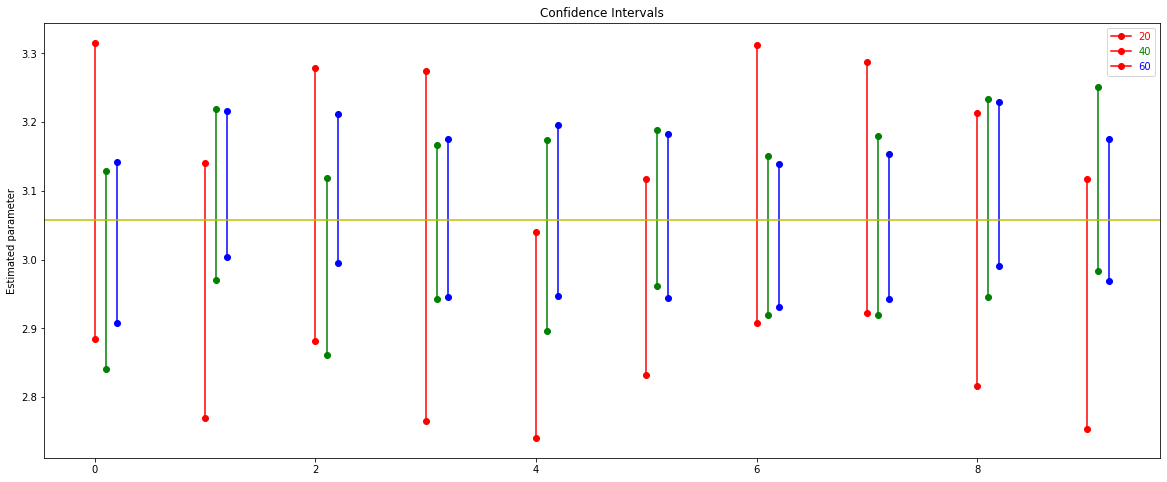

In [28]:
obs_size = [20, 40, 60]
bt_coverage = bt_replicate(sepal_width, obs_size, pop_mean, mean, get_CI_normal, 0.95, 1000)

In [35]:
bt_coverage

[[1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [33]:
def jk_replicate(data, size, pop_value, est_function, confidence, nfold=None):
    
    coverage = []
    fig, ax = plt.subplots(figsize=(20, 8))
    color = ['r', 'g', 'b']
    
    for i in range(len(size)):
        
        # randomly select 10 observed data of size[i]
        rd_data = [np.random.choice(data, size[i], replace=False) for _ in range(10)]
        
        within = []
    
        for j in range(len(rd_data)):
            observe = rd_data[j]

            lower, upper = get_jk_coverage(observe, est_function, confidence, nfold)

            ax.plot((j + 0.1 * i, j + 0.1 * i), (lower, upper), 'o-', color = color[i])
            
            if lower < pop_value < upper:
                within.append(1)
            else:
                within.append(0)
        
        coverage.append(within)
        
        
    ax.axhline(pop_value, xmin = 0, xmax = 10, color = 'y')
    ax.set(ylabel = 'Estimated parameter')
    ax.legend(labels = ['20', '40', '60'], labelcolor = color)
    ax.set_title('Confidence Intervals')

    plt.show()
    
    return coverage

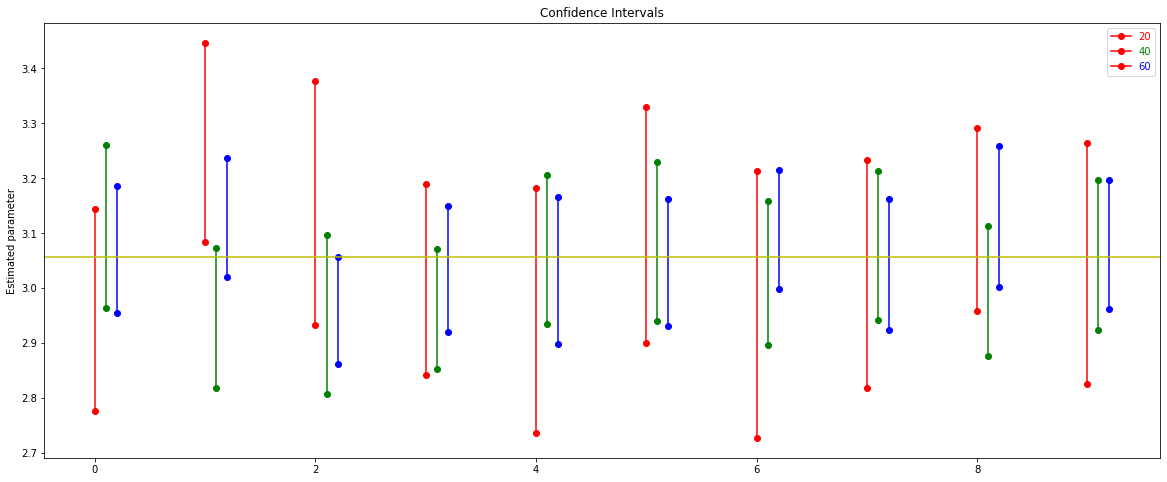

In [34]:
jk_coverage = jk_replicate(sepal_width, obs_size, pop_mean, mean, 0.95)

In [36]:
jk_coverage

[[1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]]

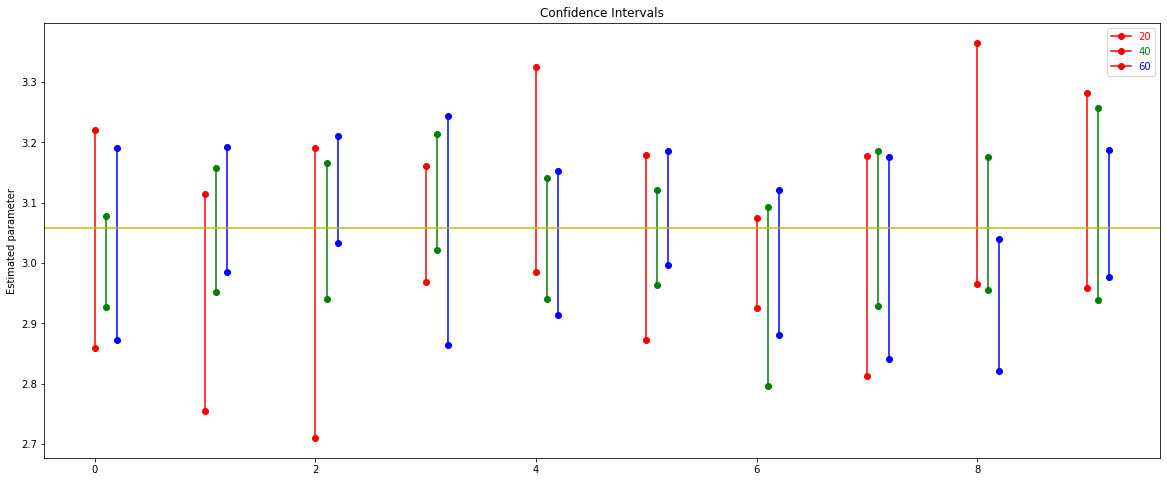

In [37]:
jk_block_coverage = jk_replicate(sepal_width, obs_size, pop_mean, mean, 0.95, 5)

In [38]:
jk_block_coverage

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 1]]

## TO BE CONTINUED

In [130]:
bt_coverage_normal = bt_coverage(obs_width, mean, get_CI_normal, 0.95, pop_mean, 20, 1000)
bt_coverage_quantile = bt_coverage(obs_width, mean, get_CI_quantile, 0.95, pop_mean, 20, 1000)
bt_coverage_biased = bt_coverage(obs_width, mean, get_CI_biased_corrected_norm, 0.95, pop_mean, 20, 1000)
jk_coverage_rate = jk_coverage(obs_width, mean, 0.95, pop_mean, 20)
jk_block_coverage = jk_coverage(obs_width, mean, 0.95, pop_mean, 20, nfold=5)

In [131]:
coverage_df = {'pop_width': [pop_mean] * 5,
               'obs_width': [mean(obs_width)] * 5,
               'resample method': ['bootstrap', 'bootstrap', 'bootstrap', 'jackknife', 'jackknife block'],
               'CI method': ['noraml', 'quantile', 'biased corrected', 'pseudo normal', 'pseudo normal'],
               'confidence': ['95%'] * 5, 
               'resample means': [bt_coverage_normal, bt_coverage_quantile, bt_coverage_biased, jk_coverage_rate, jk_block_coverage],
               'rate': [mean(bt_coverage_normal), mean(bt_coverage_quantile), 
                        mean(bt_coverage_biased), mean(jk_coverage_rate), mean(jk_block_coverage)]}

coverage_df = pd.DataFrame(coverage_df)

In [132]:
coverage_df.style

,pop_width,obs_width,resample method,CI method,confidence,resample means,rate
0,3.057333,3.110000,bootstrap,noraml,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
1,3.057333,3.110000,bootstrap,quantile,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
2,3.057333,3.110000,bootstrap,biased corrected,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
3,3.057333,3.110000,jackknife,pseudo normal,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
4,3.057333,3.110000,jackknife block,pseudo normal,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
